In [1]:
# Ocean Heat Budget Analyses in the Antarctica continental shelf (WAOM)

# Fabio B Dias - 28 June 2023
# Description:
#     this script obtain and save the 1500m isobath contour variables, which is used for the 
#     cross-shelf heat transport estimates

# read nc output from WAOM 10km run

import xarray as xr
import pandas as p
import numpy as np
import numpy.ma as ma
import cartopy.crs as ccrs
import matplotlib as mpl
# mpl.use('Agg')
import matplotlib.pyplot as plt
import matplotlib.dates as dates
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

from datetime import datetime, timedelta

from netCDF4 import Dataset
from netCDF4 import num2date, date2num
from matplotlib.ticker import NullFormatter
from matplotlib.colors import LinearSegmentedColormap   # for custom colormaps

import gsw

import pyresample

from dask.distributed import Client
import logging
import warnings
warnings.filterwarnings('ignore')


In [2]:
client = Client(n_workers=56,threads_per_worker=1, memory_limit=0, silence_logs=logging.ERROR)
client

Connection method: Cluster object,Cluster type: distributed.LocalCluster
Dashboard: /proxy/37785/status,
Dashboard: /proxy/37785/status,Workers: 56
Total threads: 56,Total memory: 0 B
Status: running,Using processes: True
Comm: tcp://127.0.0.1:33481,Workers: 56
Dashboard: /proxy/37785/status,Total threads: 56
Started: Just now,Total memory: 0 B
Comm: tcp://127.0.0.1:35255,Total threads: 1
Dashboard: /proxy/40387/status,Memory: 0 B
Nanny: tcp://127.0.0.1:45671,


In [3]:
%%time

# load ice draft to create masks
di = xr.open_dataset('/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag_daily/ocean_avg_0001.nc')
ice_draft = di.variables["zice"]

mask_zice = ma.masked_where(ice_draft < 0, np.ones(ice_draft.shape))
mask_outice = ma.masked_where(ice_draft >= 0, np.ones(ice_draft.shape))
di.close()

dg = xr.open_dataset("/g/data/hh5/tmp/access-om/fbd581/ROMS/waom10_frc/waom10extend_grd.nc")

lat_rho = dg.variables["lat_rho"]
lon_rho = dg.variables["lon_rho"]
lat_u = dg.variables["lat_u"]
lon_u = dg.variables["lon_u"]
lat_v = dg.variables["lat_v"]
lon_v = dg.variables["lon_v"]
pm = dg.variables["pm"]
pn = dg.variables["pn"]
h = dg.variables["h"]

# ds.coords['lat_rho']=lat_rho.transpose() # put lat_rho into ds dataset
# ds.coords['lon_rho']=lon_rho.transpose() # put lon_rho into ds dataset

area=np.divide(1,pm*pn)

## creating the contour, such as a isobath, and extracting the coordinates using matplotlib's Path class
# based on https://github.com/COSIMA/cosima-recipes/blob/master/DocumentedExamples/Cross-contour_transport.ipynb

h = dg.h.load()

h = h*mask_zice

# Fill in land with zeros:
h = h.fillna(0)

contour_depth = 1500.

## Choose whether you want your contour on the u or t grid.
grid_sel = 't'
if grid_sel == 'u':
    x_var = lon_u
    y_var = lat_u
elif grid_sel == 't':
    x_var = lon_rho
    y_var = lat_rho
 



0.3.0
CPU times: user 7.02 s, sys: 3.23 s, total: 10.2 s
Wall time: 11.8 s


2785


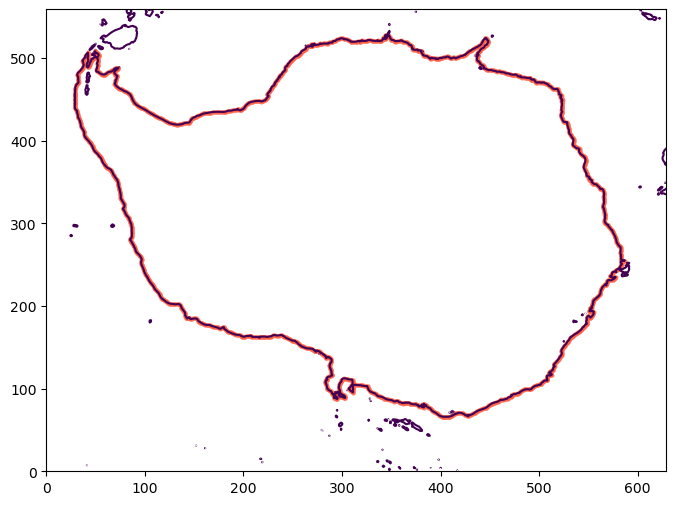

In [15]:
fig = plt.figure(figsize = (8, 6))
count = 164 # contour 87 for 2000m isobath, 165 for 1500m
x_contour = []
y_contour = []

# Create the contour:
sc = plt.contour(h, levels=[contour_depth])
for collection in sc.collections:
    for path in collection.get_paths():
       
        count += 1
        if count ==  212:
            # Write down the lat/lon indices
            print(np.size(path.vertices[:,0]))
            for ii in range(np.size(path.vertices[:,0])):
                x_contour.append(int(np.round(path.vertices[ii][0])))
                y_contour.append(int(np.round(path.vertices[ii][1])))

plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='tomato');


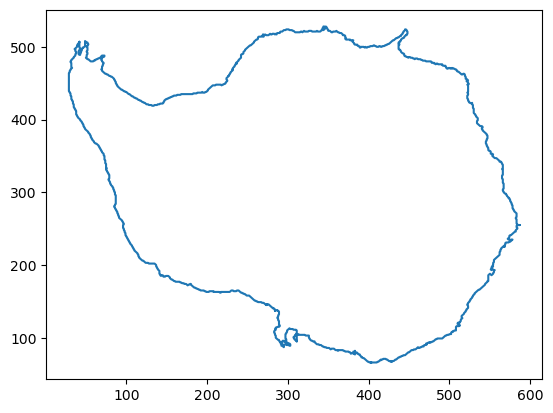

In [24]:
plt.plot(x_contour,y_contour)

In [18]:
# fig_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/figs/Contour_isobath/'

# for cc in np.arange(212):
#     fig = plt.figure(figsize = (8, 6))
#     count = cc # contour 133 for 1500m isobath, WAOM4
#     x_contour = []
#     y_contour = []

#     # Create the contour:
#     sc = plt.contour(h, levels=[contour_depth])
#     for collection in sc.collections:
#         for path in collection.get_paths():
#             # print(collection.get_paths())
        
#             count += 1
#             if count ==  212:
#                 # Write down the lat/lon indices
#                 for ii in range(np.size(path.vertices[:,0])):
#                     x_contour.append(int(np.round(path.vertices[ii][0])))
#                     y_contour.append(int(np.round(path.vertices[ii][1])))

#     plt.scatter(x_contour, y_contour, s=5, alpha=0.5, color='tomato');
#     # name_fig='WAOM10_1500m_contour_check_cc=' + str(cc) + '.png'
#     # plt.savefig(fig_path + name_fig, dpi=300)


In [5]:
%%time
## SHOULD I SMOOTH IT? PROBABLY YES!

# Difference between two neighbouring indices
diff_x_contour = np.diff(x_contour)
diff_y_contour = np.diff(y_contour)

# Get a list with the indices of duplicates
diff_ind = []
for ii in range(len(diff_x_contour)):
    if (diff_x_contour[ii]==0) and (diff_y_contour[ii]==0):
        diff_ind.append(ii)

# Now remove the indices (start from the end so the indices don't shift)
for ii in range(len(diff_ind)):
    index = diff_ind[::-1][ii]
    del x_contour[index]
    del y_contour[index]

h_contour = np.zeros(len(x_contour))

for ii in range(len(h_contour)):
    h_contour[ii] = h[y_contour[ii], x_contour[ii]]

# Get lat/lon along the contour

# Choose whether you want your contour on the u or t grid.
grid_sel = 't'

if grid_sel == 'u':
    x_var = lon_u
    y_var = lat_u
elif grid_sel == 'v':
    x_var = lon_v
    y_var = lat_v
elif grid_sel == 't':
    x_var = lon_rho
    y_var = lat_rho

lat_along_contour = np.zeros((len(x_contour)))
lon_along_contour = np.zeros((len(x_contour)))

for ii in range(len(h_contour)):
    lon_along_contour[ii] = x_var[y_contour[ii-1],x_contour[ii-1]]
    lat_along_contour[ii] = y_var[y_contour[ii-1],x_contour[ii-1]]

# Repeat the leftmost point at the end of the array.
# (Required for masking contour above and below)

lat_along_contour = np.append(lat_along_contour, lat_along_contour[0])
lon_along_contour = np.append(lon_along_contour, lon_along_contour[0])

# Number of grid points on the contour
num_points = len(lat_along_contour)

# Now we number the points along the contour
contour_mask_numbered = np.zeros_like(lon_along_contour)

for ii in range(num_points-1):
    lat1 = lat_along_contour[ii]
    lat2 = lat_along_contour[ii+1]
    lon1 = lon_along_contour[ii]
    lon2 = lon_along_contour[ii+1]
    contour_mask_numbered[ii] = ii

contour_mask = h*0

for ii in range(num_points-1):
    contour_mask[y_contour[ii], x_contour[ii]] = contour_mask_numbered[ii]+1

mask_value = -1000
contour_mask_numbered = contour_mask

# fill in points to south of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1, 0] = mask_value


CPU times: user 2.03 s, sys: 378 ms, total: 2.41 s
Wall time: 2.02 s


In [9]:
len(h_contour)


1954

In [5]:
%%time
#Create mask
#Now we create a mask below contour sothat the direction of the contour can be determined

#Remark on computational inefficiency:
#Note that creating masks with nested for loops is very inefficient. We should probably use boolean masks (just compare the entire array with mask_value), and DataArray.shift() or DataArray.roll() from each of the directions to generate the masks without using loops.
#See discussion in: https://github.com/COSIMA/cosima-recipes/issues/179

print(contour_masked_above.shape, contour_mask_numbered.shape)
print(contour_masked_above[-20:-1, 0])

# fill in points to south of contour:
contour_masked_above = np.copy(contour_mask_numbered)
contour_masked_above[-1, 0] = mask_value

# from top left:
for ii in range(len(contour_mask[0,:])-1): #x: len(x-axis) - 1
    for jj in range(len(contour_mask[:,0]))[::-1][:-1]: #y: len(y-axis)[from end to start, inverse order][from first to (end-1)]
        if contour_masked_above[jj, ii] == mask_value: # if north of contour line
            if contour_masked_above[jj-1, ii] == 0: # if previous cell in Y-dir is zero (= south of contour line)
                contour_masked_above[jj-1, ii] = mask_value # make it -1000
            if contour_masked_above[jj, ii+1] == 0: # if next cell in X-dir is zero
                contour_masked_above[jj, ii+1] = mask_value # make it -1000

#from top right:
for ii in range(len(contour_mask[0,:]))[::-1][:-1]:
    for jj in range(len(contour_mask[:,0]))[::-1][:-1]:
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj-1, ii] == 0: # if previous cell in Y-dir is zero
                contour_masked_above[jj-1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0: # if previous cell in X-dir is zero
                contour_masked_above[jj, ii-1] = mask_value

# from bottom right:
for ii in range(len(contour_mask[0,:]))[::-1][:-1]:
    for jj in range(len(contour_mask[:,0])-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0: # if next cell in Y-dir is zero
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii-1] == 0: # if previous cell in X-dir is zero
                contour_masked_above[jj, ii-1] = mask_value

#from bottom left:
for ii in range(len(contour_mask[0,:])-1):
    for jj in range(len(contour_mask[:,0])-1):
        if contour_masked_above[jj, ii] == mask_value:
            if contour_masked_above[jj+1, ii] == 0: # if next cell in Y-dir is zero
                contour_masked_above[jj+1, ii] = mask_value
            if contour_masked_above[jj, ii+1] == 0: # if next cell in X-dir is zero
                contour_masked_above[jj, ii+1] = mask_value

mask_shelf2 = ma.masked_where(contour_masked_above == -1000, np.ones(h.shape))

# Direction of cross-contour transport

mask_x_transport = np.zeros_like(contour_mask_numbered)
mask_y_transport = np.zeros_like(contour_mask_numbered)

mask_y_transport_numbered = np.zeros_like(contour_mask_numbered)
mask_x_transport_numbered = np.zeros_like(contour_mask_numbered)

# make halos: add 2 extra columns with the value of the last/first columns of the original
shape = contour_masked_above.shape
contour_masked_above_halo = np.zeros((shape[0], shape[1]+2))
contour_masked_above_halo[:, 0] = contour_masked_above[:, -1]
contour_masked_above_halo[:, 1:-1] = contour_masked_above
contour_masked_above_halo[:, -1] = contour_masked_above[:, 0]

new_number_count = 1
for mask_loc in range(1, int(np.max(contour_mask_numbered))+1):
    #if mask_loc%100 == 0:
    #    print('mask for x/y transport at point '+str(mask_loc))
    index_i = np.where(contour_mask_numbered==mask_loc)[1]
    index_j = np.where(contour_mask_numbered==mask_loc)[0]
    # if point above is towards Antarctica and point below is away from Antarctica:
    # take transport grid point to north of t grid:
    if (contour_masked_above[index_j+1, index_i]==0) and (contour_masked_above[index_j-1, index_i]!=0):
        mask_y_transport[index_j, index_i] = -1
        # important to do
        mask_y_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
    # if point below is towards Antarctica and point above is away from Antarctica:
    # take transport grid point to south of t grid:
    elif (contour_masked_above[index_j-1, index_i]==0) and (contour_masked_above[index_j+1, index_i]!=0):
        mask_y_transport[index_j-1, index_i] = 1
        mask_y_transport_numbered[index_j-1, index_i] = new_number_count
        new_number_count += 1
    # if point to right is towards Antarctica and point to left is away from Antarctica:
    # zonal indices increased by 1 due to halos
    # take transport grid point on right of t grid:
    if (contour_masked_above_halo[index_j, index_i+2]==0) and (contour_masked_above_halo[index_j, index_i]!=0):
        mask_x_transport[index_j, index_i] = -1
        mask_x_transport_numbered[index_j, index_i] = new_number_count
        new_number_count += 1
    # if point to left is towards Antarctica and point to right is away from Antarctica:
    # take transport grid point on left of t grid:
    elif (contour_masked_above_halo[index_j, index_i]==0) and (contour_masked_above_halo[index_j, index_i+2]!=0):
        mask_x_transport[index_j, index_i-1] = 1
        mask_x_transport_numbered[index_j, index_i-1] = new_number_count
        new_number_count += 1

# We now have the coordinates of the contours, and whether the x or y transport is needed to calculate cross-contour transport.

print(pm.shape, pn.shape)


(560, 630) (560, 630)
[0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
(560, 630) (560, 630)
CPU times: user 6.76 s, sys: 485 ms, total: 7.24 s
Wall time: 6.06 s


In [6]:
%%time
# Now we need to interpolate the mask_x/y_transport to the corresponding lon/lat_u/v grids
# so we can multiply by the U/V transport

# re-grid from rho to u/v-grids
rho_def = pyresample.geometry.SwathDefinition(lons=lon_rho,lats=lat_rho)
u_def = pyresample.geometry.SwathDefinition(lons=lon_u,lats=lat_u)
v_def = pyresample.geometry.SwathDefinition(lons=lon_v,lats=lat_v)

wf = lambda r: 1/r

mask_x_transport_Ugrd = pyresample.kd_tree.resample_custom(rho_def,mask_x_transport,u_def,\
                                         radius_of_influence=100000,neighbours=1,weight_funcs=wf)
mask_y_transport_Vgrd = pyresample.kd_tree.resample_custom(rho_def,mask_y_transport,v_def,\
                                         radius_of_influence=100000,neighbours=1,weight_funcs=wf)
mask_x_transport_numbered_Ugrd = pyresample.kd_tree.resample_custom(rho_def,mask_x_transport_numbered,u_def,\
                                         radius_of_influence=100000,neighbours=1,weight_funcs=wf)
mask_y_transport_numbered_Vgrd = pyresample.kd_tree.resample_custom(rho_def,mask_y_transport_numbered,v_def,\
                                         radius_of_influence=100000,neighbours=1,weight_funcs=wf)

CPU times: user 1.26 s, sys: 126 ms, total: 1.39 s
Wall time: 1.02 s


In [7]:
%%time

# Convert contour masks to data arrays, so we can multiply them later.
# We need to ensure the lat lon coordinates correspond to the actual data location:
#       The y masks are used for ty_trans, so like vhrho this should have dimensions (yu_ocean, xt_ocean).
#       The x masks are used for tx_trans, so like uhrho this should have dimensions (yt_ocean, xu_ocean).
#       However the actual name will always be simply y_ocean/x_ocean irrespective of the variable
#       to make concatenation of transports in both direction and sorting possible.
coordinates=dict(one=lon_rho, two=lat_rho)
coordinatesU=dict(one=lon_u, two=lat_u)
coordinatesV=dict(one=lon_v, two=lat_v)

mask_x_transport_Ugrd = xr.DataArray(mask_x_transport_Ugrd, coords = coordinatesU, dims = ['eta_u', 'xi_u'])
mask_y_transport_Vgrd = xr.DataArray(mask_y_transport_Vgrd, coords = coordinatesV, dims = ['eta_v', 'xi_v'])
mask_x_transport_numbered_Ugrd = xr.DataArray(mask_x_transport_numbered_Ugrd, coords = coordinatesU, dims = ['eta_u', 'xi_u'])
mask_y_transport_numbered_Vgrd = xr.DataArray(mask_y_transport_numbered_Vgrd, coords = coordinatesV, dims = ['eta_v', 'xi_v'])

# rename dimensions as simply eta/xi
mask_x_transport_Ugrd = mask_x_transport_Ugrd.rename({'eta_u': 'eta','xi_u': 'xi'})
mask_y_transport_Vgrd = mask_y_transport_Vgrd.rename({'eta_v': 'eta','xi_v': 'xi'})
mask_x_transport_numbered_Ugrd = mask_x_transport_numbered_Ugrd.rename({'eta_u': 'eta','xi_u': 'xi'})
mask_y_transport_numbered_Vgrd = mask_y_transport_numbered_Vgrd.rename({'eta_v': 'eta','xi_v': 'xi'})

# Create the contour order data-array. Note that in this procedure the x-grid counts have x-grid
#   dimensions and the y-grid counts have y-grid dimensions, but these are implicit, the dimension
#   *names* are kept general across the counts, the generic y_ocean, x_ocean, so that concatening works
#   but we dont double up with numerous counts for one lat/lon point.

# stack contour data into 1d:
mask_x_numbered_1d = mask_x_transport_numbered_Ugrd.stack(contour_index = ['eta', 'xi'])
mask_x_numbered_1d = mask_x_numbered_1d.where(mask_x_numbered_1d > 0, drop = True)

mask_y_numbered_1d = mask_y_transport_numbered_Vgrd.stack(contour_index = ['eta', 'xi'])
mask_y_numbered_1d = mask_y_numbered_1d.where(mask_y_numbered_1d > 0, drop = True)

contour_ordering = xr.concat((mask_x_numbered_1d, mask_y_numbered_1d), dim = 'contour_index', data_vars="all")
contour_ordering = contour_ordering.sortby(contour_ordering)
contour_index_array = np.arange(1, len(contour_ordering)+1)

CPU times: user 62.2 ms, sys: 12.1 ms, total: 74.3 ms
Wall time: 72.8 ms


In [19]:
mask_x_transport_Ugrd

<xarray.DataArray (eta: 560, xi: 629)>
array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])
Coordinates:
    one      (eta, xi) float64 -135.0 -135.1 -135.2 -135.3 ... 51.57 51.65 51.74
    two      (eta, xi) float64 -52.4 -52.46 -52.52 ... -52.88 -52.82 -52.75
Dimensions without coordinates: eta, xi

In [8]:
%%time

# using xr.open_mfdataset

vars2drop = ["ubar","vbar","w","Hsbl","Hbbl","swrad"]

# ds = xr.open_mfdataset(paths="/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag/ocean_avg_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=bool, drop_variables=vars2drop, decode_times=False) # , concat_dim="ocean_time"
ds = xr.open_mfdataset(paths="/g/data/hh5/tmp/access-om/fbd581/ROMS/OUTPUT/waom10extend_shflim_S_0.25Q/output_20yr_diag/ocean_avg_00*.nc" , chunks={'eta_rho': '200MB'}, parallel=True, drop_variables=vars2drop, decode_times=False) # , concat_dim="ocean_time"

#- preserving 5-days avgs
temp = ds.variables["temp"]
salt = ds.variables["salt"]
shflux = ds.variables["shflux"]
ssflux = ds.variables["ssflux"]
m = ds.variables["m"]
HvomT = ds.variables["Hvom_temp"]       ## !!! Huon_temp/Hvom_temp were not saved in the original run
HuonT = ds.variables["Huon_temp"]       ## now it's running here: /scratch/gi0/fbd581/waom4extend_shflim_S_0.25Q/output_yr10_diag
Hvom = ds.variables["Hvom"]
Huon = ds.variables["Huon"]

ds = ds.set_coords(['Cs_r', 'Cs_w', 'hc', 'h', 'Vtransform'])

Zo_rho = (ds.hc * ds.s_rho + ds.Cs_r * ds.h) / (ds.hc + ds.h)
z_rho = ds.zeta + (ds.zeta + ds.h) * Zo_rho + ds.zice
print("Vtransform=2")
Zo_w = (ds.hc * ds.s_w + ds.Cs_w * ds.h) / (ds.hc + ds.h)
z_w = ds.zeta + (ds.zeta + ds.h) * Zo_w + ds.zice

ds.close()

Vtransform=2
CPU times: user 13.1 s, sys: 3.19 s, total: 16.3 s
Wall time: 36.4 s


In [17]:
# define a function to extract any 4D var along the contour line

def extract_transp_across_contour(var_x, var_y):   # var:4D [time,eta_rho,xi_rho]

    zlen = 1#len(temp[0,:,0,0])
    tlen = 1#len(temp[:,0,0,0])
    print(tlen,zlen)
    transp_across_contour = np.empty((tlen,zlen,len(contour_ordering)))

    for tt in range(0,1):#tlen): # loop through time
        for zz in range(0,1):#zlen): # loop through z-levels
            print('Debugging high memory usage: ')
            print(tt, zz)
            
            var_x_tmp = var_x[tt,zz,:,:]*mask_x_transport_Ugrd
            var_y_tmp = var_y[tt,zz,:,:]*mask_y_transport_Vgrd

            print('var_x_tmp/var_y_tmp shapes after mask multip.:')
            print(var_x_tmp.shape, var_y_tmp.shape)
            
            # stack transports into 1d and drop any points not on contour:
            x_var_1d_tmp = var_x_tmp.stack(contour_index = ['eta', 'xi'])
            x_var_1d_tmp = x_var_1d_tmp.where(mask_x_numbered_1d>0, drop = True)
            y_var_1d_tmp = var_y_tmp.stack(contour_index = ['eta', 'xi'])
            y_var_1d_tmp = y_var_1d_tmp.where(mask_y_numbered_1d>0, drop = True)

            print('x_var_1d_tmp/y_var_1d_tmp shapes after stack:')
            print(x_var_1d_tmp.shape, y_var_1d_tmp.shape)

            # combine all points on contour:
            transp_across_contour_tmp = xr.concat((x_var_1d_tmp, y_var_1d_tmp), dim = 'contour_index')
            transp_across_contour_tmp = transp_across_contour_tmp.reset_index('contour_index') # added by fabio, otherwise it crashes due to duplicated indices
            transp_across_contour_tmp = transp_across_contour_tmp.sortby(contour_ordering) # contour_ordering is 1:2588; why should I do a sortby??
            transp_across_contour_tmp.coords['contour_index'] = contour_index_array
            transp_across_contour_tmp = transp_across_contour_tmp.load()

            # print(tt, zz, transp_across_contour_tmp.shape)
            transp_across_contour[tt,zz,:] = transp_across_contour_tmp
            del transp_across_contour_tmp

    return transp_across_contour

In [ ]:
Debugging high memory usage:
0 0
var_x_tmp/var_y_tmp shapes after mask multip.:
(560, 629, 560, 629) (559, 630, 559, 630)
x_var_1d_tmp/y_var_1d_tmp shapes after stack:
(560, 629, 1331) (559, 630, 1257)

In [18]:
%%time

# convert temp to DataArray to extract values along contour:
months=np.arange(0,73)*(5/30.41667)

# Convert heat transport to data arrays:
coordinates3Du = dict(ocean_time=months, s_rho=(['s_rho'], np.arange(0,31)),
                    eta_u=(['eta_u'], np.arange(0,560)), xi_u=(['xi_u'], np.arange(0,629)))
coordinates3Dv = dict(ocean_time=months, s_rho=(['s_rho'], np.arange(0,31)),
                    eta_v=(['eta_v'], np.arange(0,559)), xi_v=(['xi_v'], np.arange(0,630)))

# - handling x/y transports (Hvom, Huon [m3.s-1]) to calculate heat transport
Huon_xr = xr.DataArray(Huon, coords = coordinates3Du, dims = ['ocean_time','s_rho','eta_u', 'xi_u'])
Hvom_xr = xr.DataArray(Hvom, coords = coordinates3Dv, dims = ['ocean_time','s_rho','eta_v', 'xi_v'])

# rename dimensions as simply eta/xi
Huon_xr = Huon_xr.rename({'eta_u': 'eta','xi_u': 'xi'})
Hvom_xr = Hvom_xr.rename({'eta_v': 'eta','xi_v': 'xi'})

# extract variables:
# correct Huon/Hvom and HuonT/HvomT using mask_x/y_transport inside "extract_transp_across_contour"
#  - convention for the northward (+) and southward (-) across contour

# 1. vol transp
vol_trans_across_contour = extract_transp_across_contour(Huon_xr, Hvom_xr)


1 1
Debugging high memory usage: 
0 0
var_x_tmp/var_y_tmp shapes after mask multip.:
(560, 629) (559, 630)
x_var_1d_tmp/y_var_1d_tmp shapes after stack:
(1331,) (1257,)
CPU times: user 229 ms, sys: 54.5 ms, total: 284 ms
Wall time: 300 ms


In [12]:
vol_trans_across_contour.shape

(73, 31, 2588)

In [13]:
%%time

# save to netcdf file:
coordinatesC=dict(ocean_time=months, s_rho=(['s_rho'], np.arange(0,31)),
                    contour_index_array=(['contour_index_array'], np.arange(0,len(contour_index_array))))

heat_trans_across_contour_xr = xr.DataArray(vol_trans_across_contour, coords = coordinatesC, dims = ['ocean_time','s_rho','contour_index_array'])
files_path = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/'
heat_trans_across_contour_xr.to_netcdf(files_path + 'WAOM10_vol_trans_1500m_5daily_test', mode='w', format="NETCDF4")

CPU times: user 107 ms, sys: 122 ms, total: 229 ms
Wall time: 453 ms


In [14]:
# compare with original calcs:

vol_trans_across_contour2 = vol_trans_across_contour
del  vol_trans_across_contour

In [25]:
orig_file = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/WAOM10_vol_trans_1500m_5daily'

ds = xr.open_dataset(orig_file)
vol_trans_across_contour_orig = ds.variables["__xarray_dataarray_variable__"]
ds.close()


In [26]:
orig_file = '/g/data/hh5/tmp/access-om/fbd581/ROMS/postprocessing/cross_contour_tmp/WAOM10_vol_trans_1500m_5daily_test'

ds = xr.open_dataset(orig_file)
vol_trans_across_contour_orig2 = ds.variables["__xarray_dataarray_variable__"]
ds.close()


In [27]:
vol_trans_across_contour_orig.shape

(73, 31, 2588)

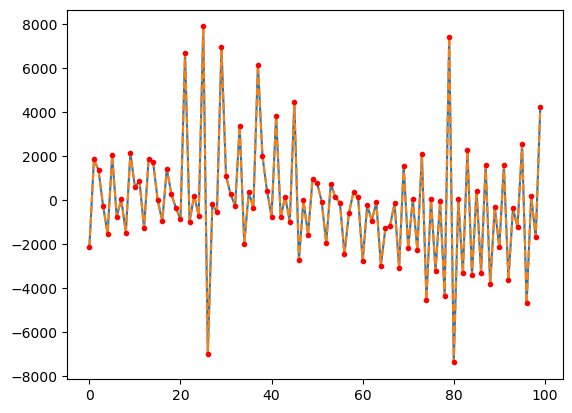

In [31]:
plt.plot(vol_trans_across_contour2[0,0,900:1000])
plt.plot(vol_trans_across_contour_orig[0,0,900:1000],'--')
plt.plot(vol_trans_across_contour_orig2[0,0,900:1000],'.r')


In [ ]:
### 